In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import os
import glob
import cv2
import pickle
%matplotlib notebook

In [2]:
fd_val = 387.5 # Based on claim in paper

# For examples

In [12]:
# Change this to the directory where you store examples
basedir = './files/' #5_10, 16_10, 147_10
image_index = '000007_10'
l_ifile = basedir+image_index+'_l.png'
r_ifile = basedir+image_index+'_r.png'
disp_file = basedir+image_index+'_dnoc.png'
#yolo_img = cv2.imread(basedir+image_index+'_yolo.png',0)
imL = cv2.imread(l_ifile,0)
imR = cv2.imread(r_ifile,0)
disp_gt = cv2.imread(disp_file,0)
plt.rcParams["figure.figsize"] = (11,4)
results = pickle.load(open('./files/results.p','rb'))
myresult = results[image_index+'.png']

# For dataset

In [11]:
# Change this to the directory where you store KITTI data
basedir = '../data_stereo_flow/training/'
image_index = '000007_10'
l_ifile = basedir+'image_0/'+image_index+'.png'
r_ifile = basedir+'image_1/'+image_index+'.png'
disp_file = basedir+'disp_noc/'+image_index+'.png'
imL = cv2.imread(l_ifile,0)
imR = cv2.imread(r_ifile,0)
disp_gt = cv2.imread(disp_file,0)
plt.rcParams["figure.figsize"] = (11,4)
results = pickle.load(open('../../yad2k/results.p','rb'))
myresult = results[image_index+'.png']

# Plot left figure and ground truth disparity

[['parking meter 0.32', (579, 181), (632, 230)],
 ['tvmonitor 0.61', (1159, 48), (1235, 178)],
 ['car 0.64', (414, 194), (524, 250)],
 ['car 0.74', (0, 193), (371, 376)]]

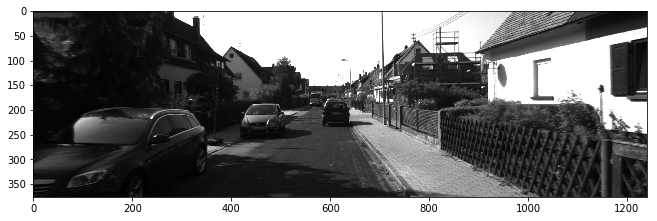

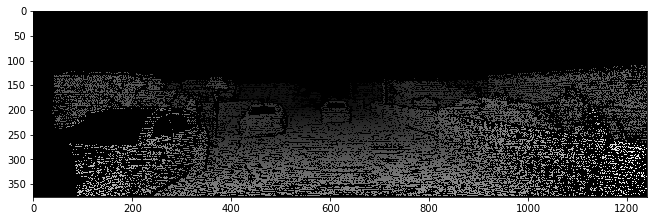

In [13]:
plt.figure()
plt.imshow(imL,cmap='gray')
plt.figure()
plt.imshow(disp_gt,cmap='gray')
myresult

# Compute disparity

In [14]:
window_size = 3
min_disp=16
num_disp=112-min_disp
#stereo = cv2.createStereoBM(numDisparities=16, blockSize=15)
stereo = cv2.StereoSGBM_create(minDisparity = min_disp, numDisparities=num_disp, blockSize=16,P1 = 8*3*window_size**2,
        P2 = 32*3*window_size**2,
        disp12MaxDiff = 1,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
speckleRange = 32)
disp = stereo.compute(imL,imR).astype(np.float32)/16 # 4 fractional bits 
(m,n) = imL.shape
rectangle = (0,0,n,m)
#rectangle = (286,162,535,288) #(300,168,436,235)
(num_samples,num_errors)=(0,0)
av_disp=0
for ii in range(rectangle[1],rectangle[3]):
    for jj in range(rectangle[0],rectangle[2]):
        dgt = disp_gt[ii,jj]
        dcomp = disp[ii,jj]
        av_disp += dcomp
        if dgt > 0:
            num_samples += 1
            if abs(dgt-dcomp) > 3:
                num_errors += 1
av_disp /= ((rectangle[3]-rectangle[1])* (rectangle[2]-rectangle[0]))
net_depth = fd_val/av_disp
print('nSamples={}, nErrors={}, Accuracy={:.2f}'.format(num_samples,num_errors,100.0*(1-num_errors/num_samples)))
#print('nSamples={}, nErrors={}, Accuracy={:.2f}, AvDisp={:.2f}, Depth={:.2f}'.format(num_samples,num_errors,100.0*(1-num_errors/num_samples),av_disp,net_depth))


nSamples=123535, nErrors=33251, Accuracy=73.08


pixel= (206, 421)  gt= 0 inf  computed_disp= 24.0625 16.1038961039
pixel= (222, 742)  gt= 25 15.5  computed_disp= 24.9375 15.5388471178


/home/subbu/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


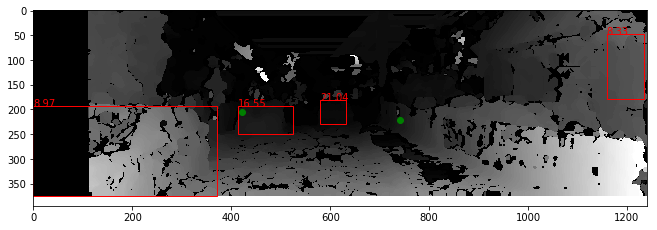

In [15]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
plt.imshow(disp.astype(int),cmap = 'gray')
for boxes in myresult:
    label,topleft,botright = boxes
    (num_samples,num_errors)=(0,0)
    av_disp = 0
    for ii in range(topleft[1],botright[1]):
        for jj in range(topleft[0],botright[0]):
            dcomp = disp[ii,jj]
            av_disp += dcomp
    av_disp /= ((botright[0]-topleft[0])* (botright[1]-topleft[1]))
    net_depth = fd_val/av_disp
    rect = plt.Rectangle(topleft,(botright[0]-topleft[0]),(botright[1]-topleft[1]),edgecolor='r',fill=False)
    ax1.add_patch(rect)
    #label = label+'Depth={:.2f}'.format(net_depth)
    label = '{:.2f}'.format(net_depth)
    plt.text(topleft[0],topleft[1],label,color='r')
#pixels = [(188,527),(160,583),(156,590)] #000147_10
#pixels = [(295,176),(330,953),(237,609),(210,546),(239,1116),(256,1121)] #000016_10
pixels = [(206,421),(222,742)] #000005_10
for pixel in pixels:
    plt.plot(pixel[1],pixel[0],'go')
    dgt = disp_gt[pixel[0],pixel[1]]
    dcomp = disp[pixel[0],pixel[1]]
    print('pixel=',pixel,' gt=',dgt,387.5/dgt,' computed_disp=',dcomp,387.5/dcomp)

In [8]:
imL.shape

(370, 1226)